In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
# código de soporte

In [ ]:
'''
def matriz_de_confusion(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión"""
    print('Reales:', clases_reales.reshape(-1))
    print('Predichas:', clases_predichas)
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)

    # Código de matplotlib para graficar
    plt.figure(figsize=(4,4))
    matriz = pd.DataFrame(matriz,
                          columns=['0 : ataque', '1 : ataque'])
    plt.matshow(matriz, cmap='Pastel1', vmi=0, vmax=20, fignum=1)
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (('Verdaderos\nnegativos','Falsos\npositivos'),
                 ('Falsos\negativos','Verdaderos\positivos'))
    plt.text(1.60, -0.30, titulo, fontsize=25, c='red')
    plt.text(2.1, 0.10, 'Accuracy: %0.2f' % accuracy, fontsize=20)
    for i in range(len(matriz.columns)):
        for j in range (len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fonsize=30, ha='center', va='center')
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha='center', va='center')
            plt.show()
'''

In [ ]:
# Dataset de detección de ictus
# 8 variables
# 0 : no ictus, 1 : ictus



In [44]:
data = pd.read_csv('stroke_dataset_processed.csv')

In [45]:
print(data.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
smoking_status        object
stroke                 int64
dtype: object


In [46]:
data['age'] = data['age'].astype(int)

In [47]:
le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])
data['smoking_status'] = le.fit_transform(data['smoking_status'])

In [48]:
print(data.dtypes)

gender                 int64
age                    int64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
smoking_status         int64
stroke                 int64
dtype: object


Historial de análisis

SMOKING_STATUS:

never smoked  -  1
formerly smoked  -  0
smokes  -  2

GENDER:

male  -  1
female  -  0

In [50]:
# Vemos las clases de smoking_status

clases = data['smoking_status'].unique()
print(clases)

[1 0 2]


Asegúrate de ajustar los porcentajes (test_size) según tus necesidades y el tamaño de tu conjunto de datos. Usar un random_state asegura que la división sea reproducible.

In [51]:
from sklearn.model_selection import train_test_split

# Primero, divide los datos en entrenamiento+validación y prueba (80% y 20% por ejemplo)
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Luego, divide entrenamiento+validación en entrenamiento y validación (75% y 25% por ejemplo)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)
# Esto resulta en:
# - 60% entrenamiento
# - 20% validación
# - 20% prueba

REDUCIR LA CLASE MAYORITARIA en el conjunto de entrenamiento train_data utilizando RandomUnderSampler de imbalanced-learn

In [52]:
from imblearn.under_sampling import RandomUnderSampler

# Separar las características (X) y la variable objetivo (y)
X_train = train_data.drop('stroke', axis=1)
y_train = train_data['stroke']

# Aplicar submuestreo aleatorio a la clase mayoritaria
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Crear un nuevo DataFrame con los datos balanceados
train_data_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), y_resampled], axis=1)

# Opcional: Restablecer el índice del DataFrame
train_data_balanced.reset_index(drop=True, inplace=True)


In [54]:
# Verificacion de Duplicados

duplicados = train_data_balanced.duplicated()

# Contar el número de duplicados
numero_duplicados = duplicados.sum()

# Mostrar los resultados
if numero_duplicados > 0:
    print(f"Se encontraron {numero_duplicados} filas duplicadas.")
    
    # Opcional: mostrar las filas duplicadas
    print("\nFilas duplicadas:")
    print(train_data_balanced[duplicados])
else:
    print("No se encontraron filas duplicadas en el dataset.")

No se encontraron filas duplicadas en el dataset.


### Preparación de los Datos

In [55]:
# Separar características y variable objetivo en cada conjunto
X_train = train_data_balanced.drop('stroke', axis=1)
y_train = train_data_balanced['stroke']

X_val = val_data.drop('stroke', axis=1)
y_val = val_data['stroke']

X_test = test_data.drop('stroke', axis=1)
y_test = test_data['stroke']

### Modelos

Regresión Logística

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Definir el modelo y los hiperparámetros a ajustar
lr = LogisticRegression(max_iter=1000, random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Configurar GridSearchCV con validación cruzada
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1)

# Entrenar el modelo
grid_search_lr.fit(X_train, y_train)

# Mejor modelo
best_lr = grid_search_lr.best_estimator_
print("Mejores hiperparámetros de Regresión Logística:", grid_search_lr.best_params_)


Mejores hiperparámetros de Regresión Logística: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


Evaluación en Conjuntos de Entrenamiento, Validación y Prueba

Evaluación en Conjunto de Entrenamiento - Regresión Logística
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       148
           1       0.70      0.77      0.74       148

    accuracy                           0.72       296
   macro avg       0.72      0.72      0.72       296
weighted avg       0.72      0.72      0.72       296



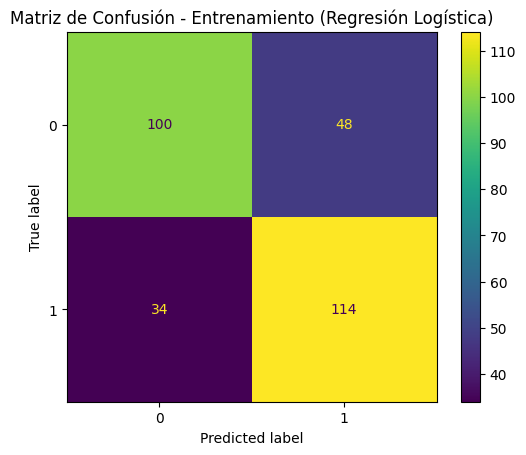

Evaluación en Conjunto de Validación - Regresión Logística
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       622
           1       0.18      0.82      0.30        51

    accuracy                           0.70       673
   macro avg       0.58      0.76      0.55       673
weighted avg       0.92      0.70      0.77       673



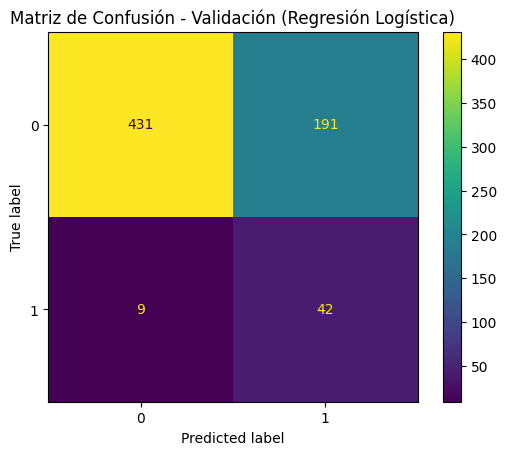

Evaluación en Conjunto de Prueba - Regresión Logística
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       626
           1       0.18      0.74      0.29        47

    accuracy                           0.74       673
   macro avg       0.58      0.74      0.56       673
weighted avg       0.92      0.74      0.80       673



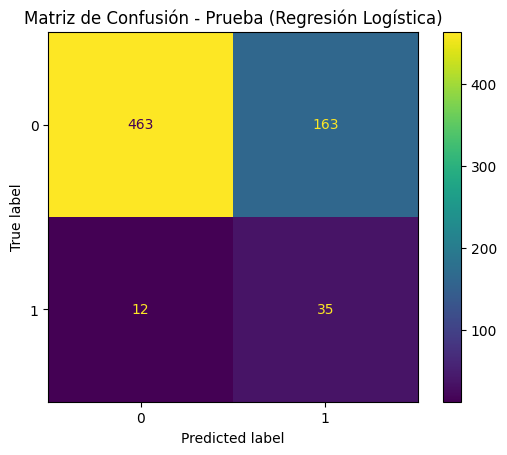

In [66]:
# Evaluación en Entrenamiento
y_train_pred_lr = best_lr.predict(X_train)
print("Evaluación en Conjunto de Entrenamiento - Regresión Logística")
print(classification_report(y_train, y_train_pred_lr))

cm_train_lr = confusion_matrix(y_train, y_train_pred_lr)
ConfusionMatrixDisplay(cm_train_lr).plot()
plt.title("Matriz de Confusión - Entrenamiento (Regresión Logística)")
plt.show()

# Evaluación en Validación
y_val_pred_lr = best_lr.predict(X_val)
print("Evaluación en Conjunto de Validación - Regresión Logística")
print(classification_report(y_val, y_val_pred_lr))

cm_val_lr = confusion_matrix(y_val, y_val_pred_lr)
ConfusionMatrixDisplay(cm_val_lr).plot()
plt.title("Matriz de Confusión - Validación (Regresión Logística)")
plt.show()

# Evaluación en Prueba
y_test_pred_lr = best_lr.predict(X_test)
print("Evaluación en Conjunto de Prueba - Regresión Logística")
print(classification_report(y_test, y_test_pred_lr))

cm_test_lr = confusion_matrix(y_test, y_test_pred_lr)
ConfusionMatrixDisplay(cm_test_lr).plot()
plt.title("Matriz de Confusión - Prueba (Regresión Logística)")
plt.show()


### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Definir el modelo y los hiperparámetros a ajustar
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

# Entrenar el modelo
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_
print("Mejores hiperparámetros de Random Forest:", grid_search_rf.best_params_)


Mejores hiperparámetros de Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


Evaluación en Conjuntos de Entrenamiento, Validación y Prueba

Evaluación en Conjunto de Entrenamiento - Random Forest
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       148
           1       0.92      0.94      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



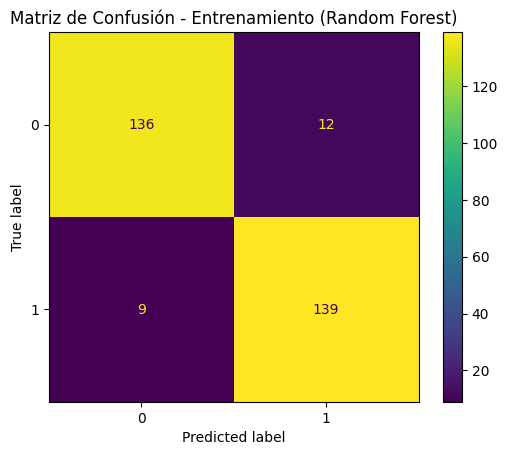

Evaluación en Conjunto de Validación - Random Forest
              precision    recall  f1-score   support

           0       0.97      0.63      0.76       622
           1       0.15      0.78      0.25        51

    accuracy                           0.64       673
   macro avg       0.56      0.71      0.51       673
weighted avg       0.91      0.64      0.72       673



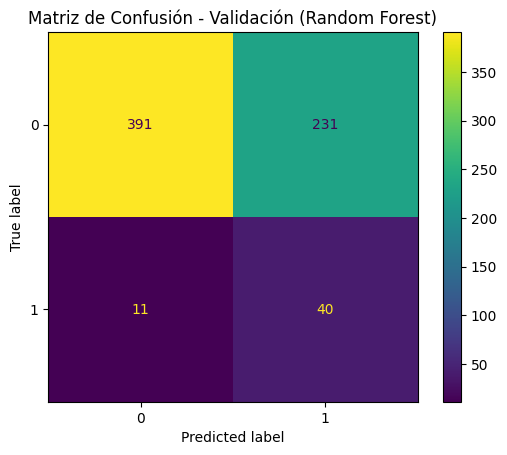

Evaluación en Conjunto de Prueba - Random Forest
              precision    recall  f1-score   support

           0       0.98      0.60      0.74       626
           1       0.14      0.87      0.24        47

    accuracy                           0.62       673
   macro avg       0.56      0.74      0.49       673
weighted avg       0.93      0.62      0.71       673



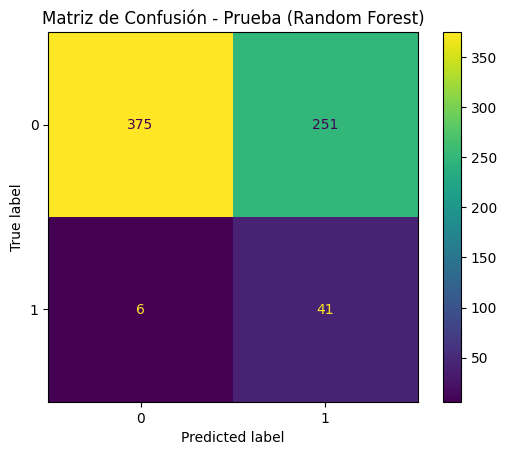

In [68]:
# Evaluación en Entrenamiento
y_train_pred_rf = best_rf.predict(X_train)
print("Evaluación en Conjunto de Entrenamiento - Random Forest")
print(classification_report(y_train, y_train_pred_rf))

cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
ConfusionMatrixDisplay(cm_train_rf).plot()
plt.title("Matriz de Confusión - Entrenamiento (Random Forest)")
plt.show()

# Evaluación en Validación
y_val_pred_rf = best_rf.predict(X_val)
print("Evaluación en Conjunto de Validación - Random Forest")
print(classification_report(y_val, y_val_pred_rf))

cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
ConfusionMatrixDisplay(cm_val_rf).plot()
plt.title("Matriz de Confusión - Validación (Random Forest)")
plt.show()

# Evaluación en Prueba
y_test_pred_rf = best_rf.predict(X_test)
print("Evaluación en Conjunto de Prueba - Random Forest")
print(classification_report(y_test, y_test_pred_rf))

cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)
ConfusionMatrixDisplay(cm_test_rf).plot()
plt.title("Matriz de Confusión - Prueba (Random Forest)")
plt.show()


###  XGBoost

In [69]:
import xgboost as xgb

# Definir el modelo y los hiperparámetros a ajustar
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]
}

# Configurar GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)

# Entrenar el modelo
grid_search_xgb.fit(X_train, y_train)

# Mejor modelo
best_xgb = grid_search_xgb.best_estimator_
print("Mejores hiperparámetros de XGBoost:", grid_search_xgb.best_params_)


Mejores hiperparámetros de XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}


c:\Users\busin\Desktop\mode_ic\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluación en Conjuntos de Entrenamiento, Validación y Prueba

Evaluación en Conjunto de Entrenamiento - XGBoost
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       148
           1       0.72      0.91      0.80       148

    accuracy                           0.78       296
   macro avg       0.80      0.78      0.77       296
weighted avg       0.80      0.78      0.77       296



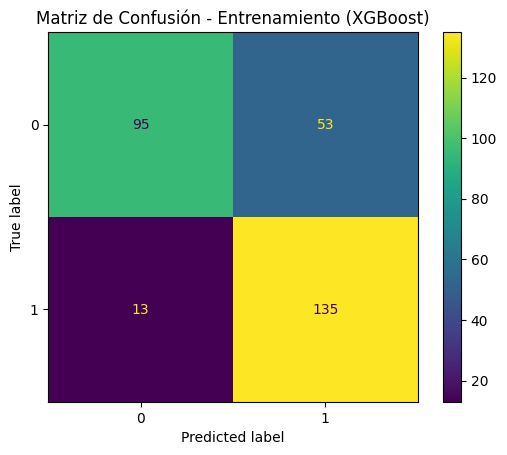

Evaluación en Conjunto de Validación - XGBoost
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       622
           1       0.15      0.86      0.25        51

    accuracy                           0.60       673
   macro avg       0.56      0.72      0.49       673
weighted avg       0.92      0.60      0.70       673



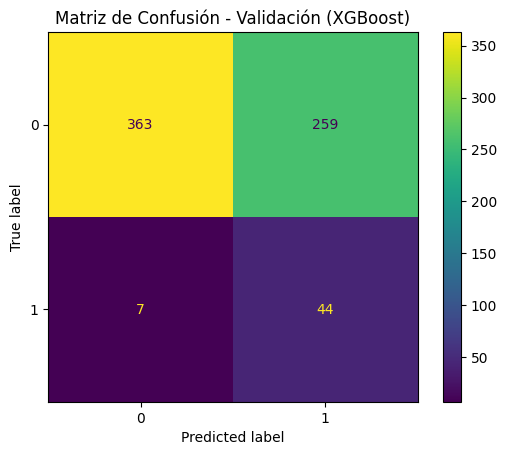

Evaluación en Conjunto de Prueba - XGBoost
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       626
           1       0.13      0.89      0.23        47

    accuracy                           0.59       673
   macro avg       0.56      0.73      0.48       673
weighted avg       0.93      0.59      0.69       673



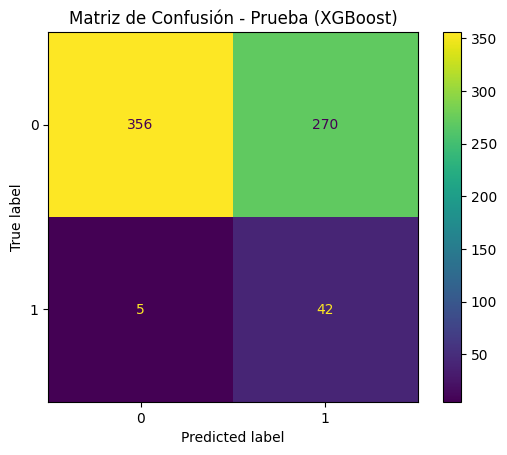

In [70]:
# Evaluación en Entrenamiento
y_train_pred_xgb = best_xgb.predict(X_train)
print("Evaluación en Conjunto de Entrenamiento - XGBoost")
print(classification_report(y_train, y_train_pred_xgb))

cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
ConfusionMatrixDisplay(cm_train_xgb).plot()
plt.title("Matriz de Confusión - Entrenamiento (XGBoost)")
plt.show()

# Evaluación en Validación
y_val_pred_xgb = best_xgb.predict(X_val)
print("Evaluación en Conjunto de Validación - XGBoost")
print(classification_report(y_val, y_val_pred_xgb))

cm_val_xgb = confusion_matrix(y_val, y_val_pred_xgb)
ConfusionMatrixDisplay(cm_val_xgb).plot()
plt.title("Matriz de Confusión - Validación (XGBoost)")
plt.show()

# Evaluación en Prueba
y_test_pred_xgb = best_xgb.predict(X_test)
print("Evaluación en Conjunto de Prueba - XGBoost")
print(classification_report(y_test, y_test_pred_xgb))

cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
ConfusionMatrixDisplay(cm_test_xgb).plot()
plt.title("Matriz de Confusión - Prueba (XGBoost)")
plt.show()


### Gradient Boosting

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

# Definir el modelo y los hiperparámetros a ajustar
gbc = GradientBoostingClassifier(random_state=42)
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

# Configurar GridSearchCV
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring='f1', n_jobs=-1)

# Entrenar el modelo
grid_search_gbc.fit(X_train, y_train)

# Mejor modelo
best_gbc = grid_search_gbc.best_estimator_
print("Mejores hiperparámetros de Gradient Boosting:", grid_search_gbc.best_params_)


Mejores hiperparámetros de Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Evaluación en Conjuntos de Entrenamiento, Validación y Prueba

Evaluación en Conjunto de Entrenamiento - Gradient Boosting
              precision    recall  f1-score   support

           0       0.90      0.64      0.75       148
           1       0.72      0.93      0.81       148

    accuracy                           0.78       296
   macro avg       0.81      0.78      0.78       296
weighted avg       0.81      0.78      0.78       296



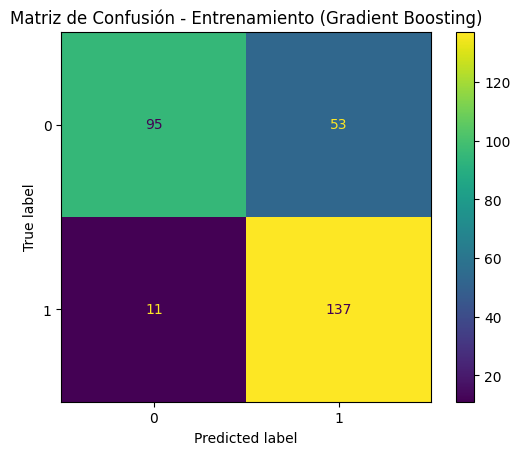

Evaluación en Conjunto de Validación - Gradient Boosting
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       622
           1       0.14      0.86      0.24        51

    accuracy                           0.58       673
   macro avg       0.56      0.71      0.48       673
weighted avg       0.92      0.58      0.68       673



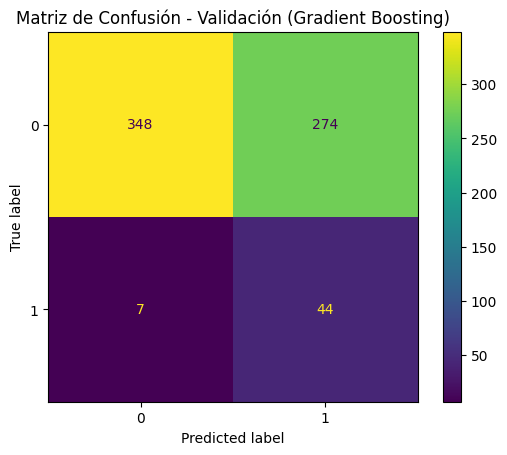

Evaluación en Conjunto de Prueba - Gradient Boosting
              precision    recall  f1-score   support

           0       0.99      0.54      0.69       626
           1       0.13      0.91      0.23        47

    accuracy                           0.56       673
   macro avg       0.56      0.73      0.46       673
weighted avg       0.93      0.56      0.66       673



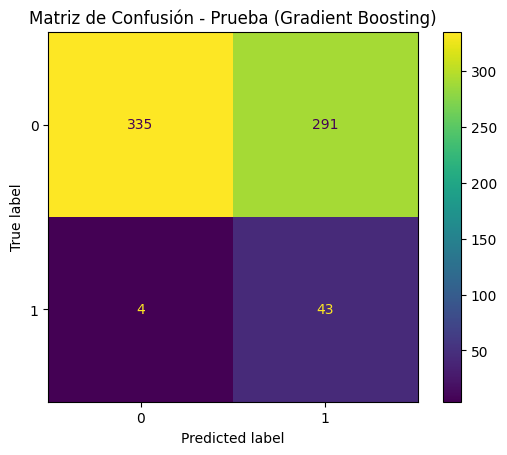

In [72]:
# Evaluación en Entrenamiento
y_train_pred_gbc = best_gbc.predict(X_train)
print("Evaluación en Conjunto de Entrenamiento - Gradient Boosting")
print(classification_report(y_train, y_train_pred_gbc))

cm_train_gbc = confusion_matrix(y_train, y_train_pred_gbc)
ConfusionMatrixDisplay(cm_train_gbc).plot()
plt.title("Matriz de Confusión - Entrenamiento (Gradient Boosting)")
plt.show()

# Evaluación en Validación
y_val_pred_gbc = best_gbc.predict(X_val)
print("Evaluación en Conjunto de Validación - Gradient Boosting")
print(classification_report(y_val, y_val_pred_gbc))

cm_val_gbc = confusion_matrix(y_val, y_val_pred_gbc)
ConfusionMatrixDisplay(cm_val_gbc).plot()
plt.title("Matriz de Confusión - Validación (Gradient Boosting)")
plt.show()

# Evaluación en Prueba
y_test_pred_gbc = best_gbc.predict(X_test)
print("Evaluación en Conjunto de Prueba - Gradient Boosting")
print(classification_report(y_test, y_test_pred_gbc))

cm_test_gbc = confusion_matrix(y_test, y_test_pred_gbc)
ConfusionMatrixDisplay(cm_test_gbc).plot()
plt.title("Matriz de Confusión - Prueba (Gradient Boosting)")
plt.show()


### Resumir las Métricas de Rendimiento

In [74]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Lista de modelos y sus nombres
modelos = {
    'Regresión Logística': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'Gradient Boosting': best_gbc
}

# Función para calcular métricas
def calcular_metricas(modelo, X, y):
    y_pred = modelo.predict(X)
    # Algunas implementaciones de modelos no tienen predict_proba
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X)[:,1]
    elif hasattr(modelo, "decision_function"):
        # Para modelos como SVM
        y_proba = modelo.decision_function(X)
    else:
        y_proba = None
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1-Score': f1_score(y, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y, y_proba) if y_proba is not None else None
    }
    return metrics

# Conjuntos de datos
conjuntos = {
    'Entrenamiento': (X_train, y_train),
    'Validación': (X_val, y_val),
    'Prueba': (X_test, y_test)
}

# Lista para almacenar resultados
resultados_list = []

# Calcular métricas para cada modelo y conjunto
for nombre_modelo, modelo in modelos.items():
    for nombre_conjunto, (X, y) in conjuntos.items():
        metricas = calcular_metricas(modelo, X, y)
        resultados_list.append({
            'Modelo': nombre_modelo,
            'Conjunto': nombre_conjunto,
            'Accuracy': metricas['Accuracy'],
            'Precision': metricas['Precision'],
            'Recall': metricas['Recall'],
            'F1-Score': metricas['F1-Score'],
            'ROC-AUC': metricas['ROC-AUC']
        })

# Crear DataFrame a partir de la lista
resultados = pd.DataFrame(resultados_list)

# Mostrar resultados
print(resultados)


                 Modelo       Conjunto  Accuracy  Precision    Recall  \
0   Regresión Logística  Entrenamiento  0.722973   0.703704  0.770270   
1   Regresión Logística     Validación  0.702823   0.180258  0.823529   
2   Regresión Logística         Prueba  0.739970   0.176768  0.744681   
3         Random Forest  Entrenamiento  0.929054   0.920530  0.939189   
4         Random Forest     Validación  0.640416   0.147601  0.784314   
5         Random Forest         Prueba  0.618128   0.140411  0.872340   
6               XGBoost  Entrenamiento  0.777027   0.718085  0.912162   
7               XGBoost     Validación  0.604755   0.145215  0.862745   
8               XGBoost         Prueba  0.591382   0.134615  0.893617   
9     Gradient Boosting  Entrenamiento  0.783784   0.721053  0.925676   
10    Gradient Boosting     Validación  0.582467   0.138365  0.862745   
11    Gradient Boosting         Prueba  0.561664   0.128743  0.914894   

    F1-Score   ROC-AUC  
0   0.735484  0.783556  
